# **Architecture Diagram**

In [24]:
!pip install diagrams

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 25.1 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.21
    Uninstalling graphviz-0.21:
      Successfully uninstalled graphviz-0.21


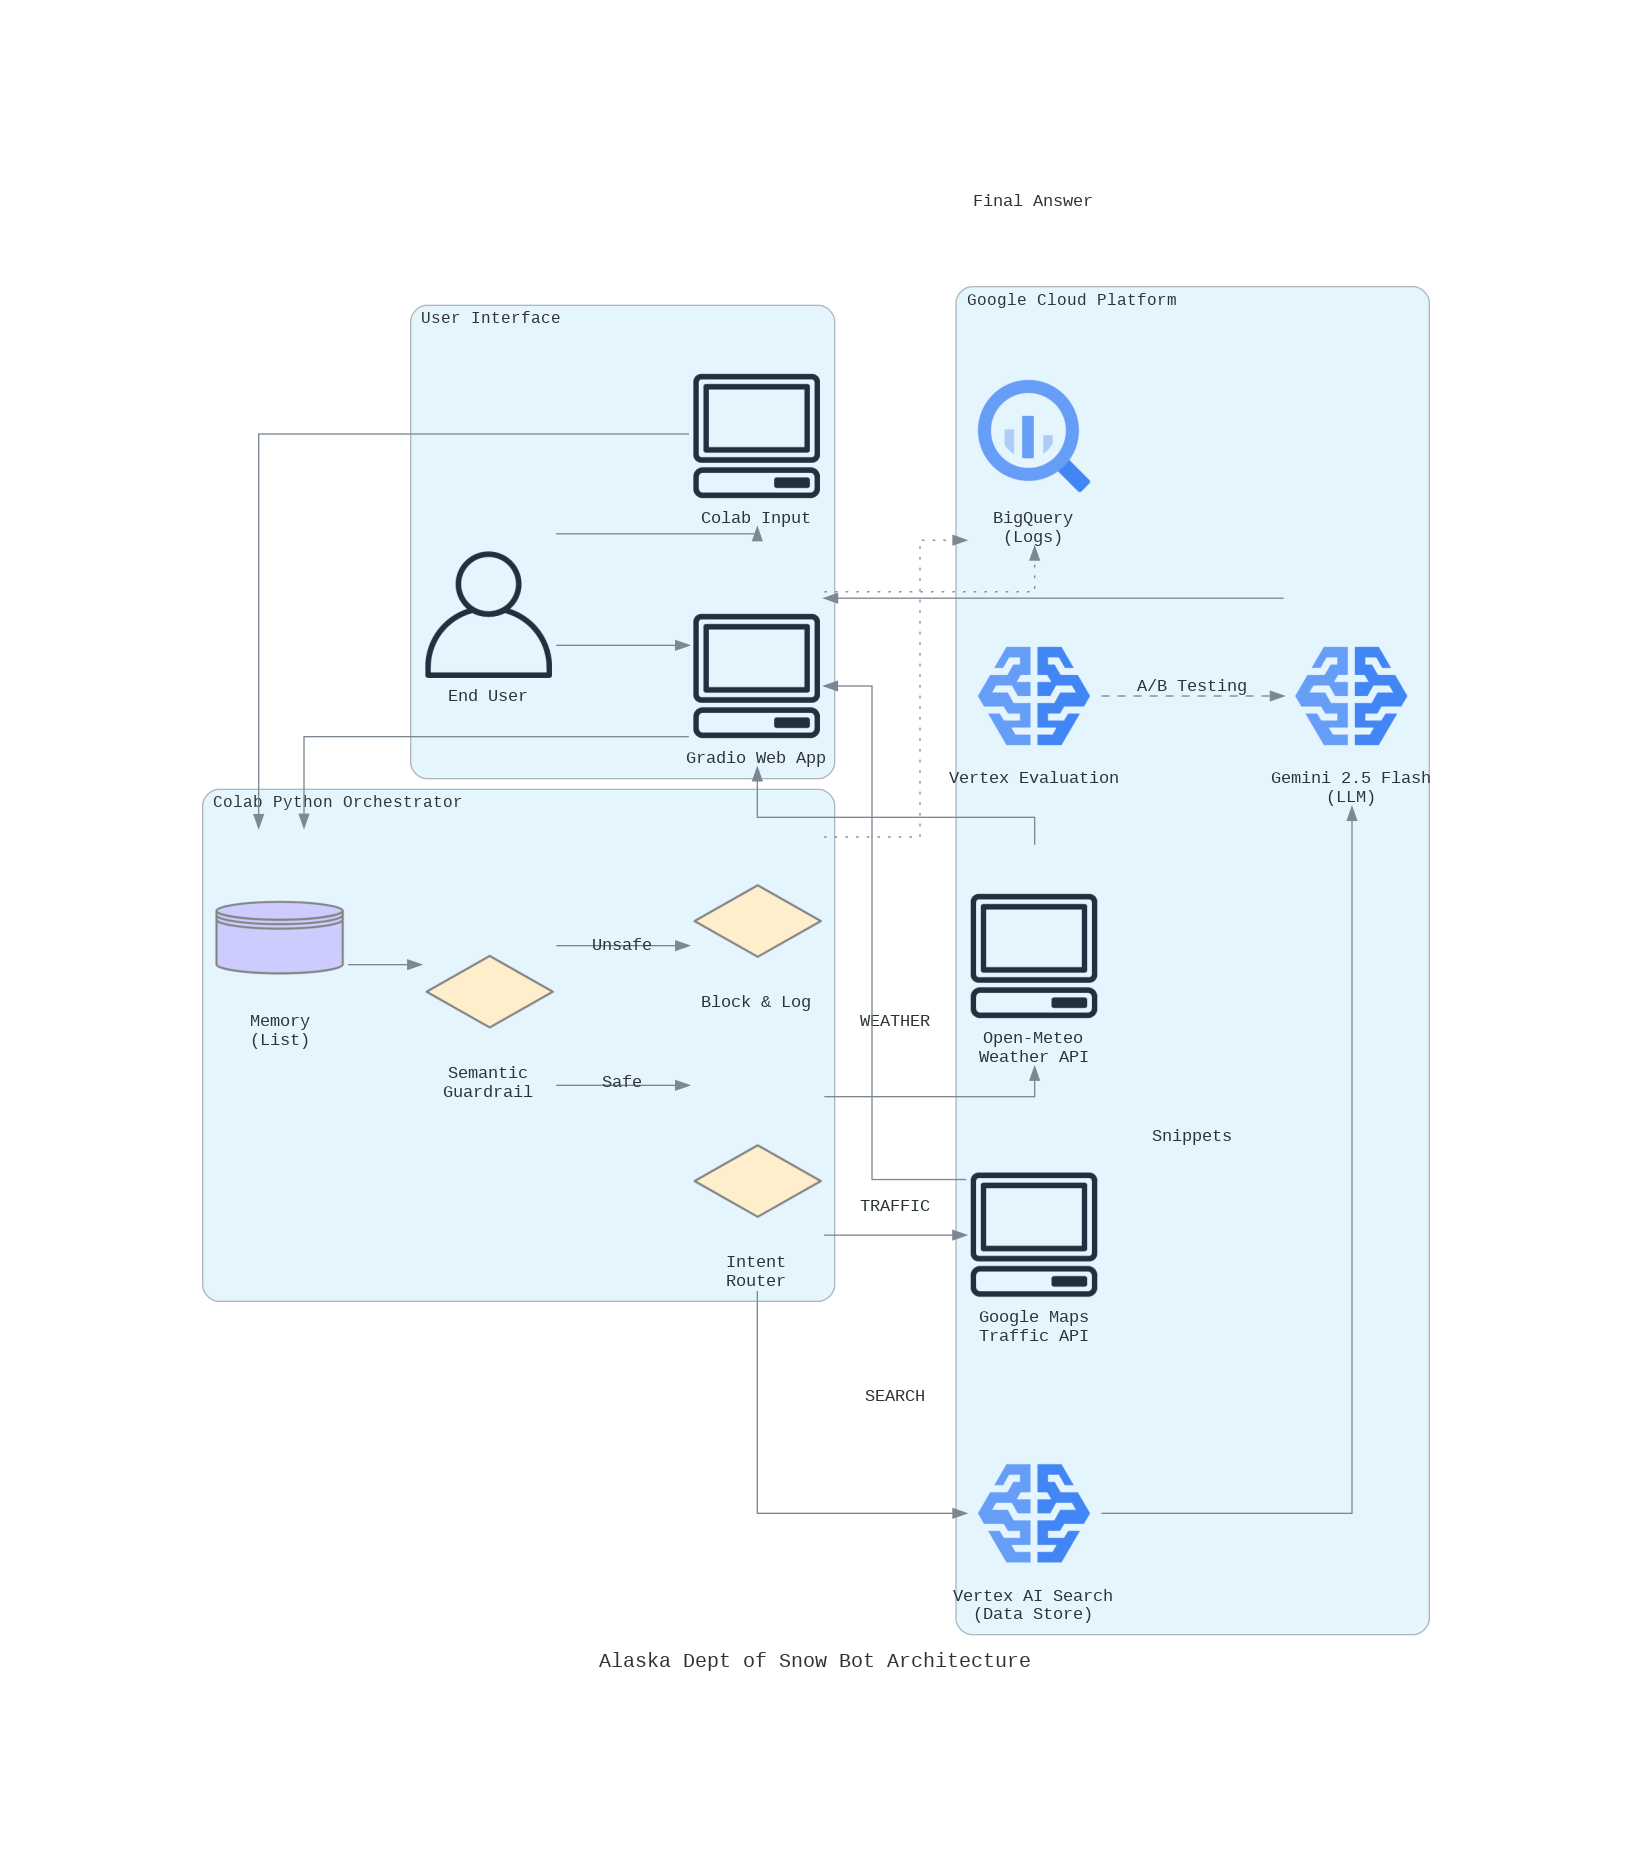

In [27]:
from diagrams import Cluster, Diagram, Edge
from diagrams.gcp.analytics import BigQuery
from diagrams.gcp.ml import AIPlatform
from diagrams.onprem.client import User, Client
from diagrams.custom import Custom
from diagrams.programming.flowchart import Decision, Database
from IPython.display import Image

# Define the diagram
with Diagram("Alaska Dept of Snow Bot Architecture", show=False, filename="alaska_bot_architecture", direction="LR"):

    # 1. User Entry Points
    with Cluster("User Interface"):
        user = User("End User")
        gradio = Client("Gradio Web App")
        colab = Client("Colab Input")
        user >> [gradio, colab]

    # 2. The Python Application Logic (The Orchestrator)
    with Cluster("Colab Python Orchestrator"):

        # Memory
        memory = Database("Memory\n(List)")

        # Safety Check
        guardrail = Decision("Semantic\nGuardrail")

        # Intent Classifier
        intent = Decision("Intent\nRouter")

        # Logic Flow
        [gradio, colab] >> memory >> guardrail

        # If Safe -> Intent
        guardrail >> Edge(label="Safe") >> intent

        # If Unsafe -> Block
        block = Decision("Block & Log")
        guardrail >> Edge(label="Unsafe") >> block

    # 3. Google Cloud Services
    with Cluster("Google Cloud Platform"):

        # Vertex AI Components
        gemini = AIPlatform("Gemini 2.5 Flash\n(LLM)")
        vertex_search = AIPlatform("Vertex AI Search\n(Data Store)")
        eval_service = AIPlatform("Vertex Evaluation")

        # Logging
        bq = BigQuery("BigQuery\n(Logs)")

        # External APIs (represented as Custom nodes or Generic)
        weather_api = Client("Open-Meteo\nWeather API")
        maps_api = Client("Google Maps\nTraffic API")

    # --- CONNECTIONS ---

    # Intent Routing
    intent >> Edge(label="SEARCH") >> vertex_search
    intent >> Edge(label="WEATHER") >> weather_api
    intent >> Edge(label="TRAFFIC") >> maps_api

    # RAG Flow
    vertex_search >> Edge(label="Snippets") >> gemini

    # Evaluation Flow (Offline)
    eval_service >> Edge(style="dashed", label="A/B Testing") >> gemini

    # Final Response Assembly
    gemini >> Edge(label="Final Answer") >> gradio
    weather_api >> gradio
    maps_api >> gradio

    # Logging Everything
    gradio >> Edge(style="dotted") >> bq
    block >> Edge(style="dotted") >> bq

# Display the generated image in the notebook
display(Image(filename="alaska_bot_architecture.png"))

# **Dependencies and Configuration**

In [1]:
# Install the Vertex AI and Discovery Engine (Search) libraries
!pip install --upgrade google-cloud-discoveryengine google-cloud-aiplatform -q

print("Libraries installed.")

Libraries installed.


In [29]:
import sys
import requests
import unittest
import pandas as pd
import getpass
from google.colab import auth
from google.api_core.client_options import ClientOptions
from google.cloud import discoveryengine_v1 as discoveryengine
from google.cloud import secretmanager
from vertexai.generative_models import GenerativeModel, HarmCategory, HarmBlockThreshold
from vertexai.evaluation import EvalTask, PointwiseMetric # <--- NEW: Evaluation Library
import vertexai

# --- CONFIGURATION ---
PROJECT_ID = "qwiklabs-gcp-03-c72749959822"
DATA_STORE_ID = "alaska-dept-of-snow-datastore_1763052856729"
LOCATION = "us"

# Authenticate & Initialize
if "google.colab" in sys.modules:
    auth.authenticate_user()

vertexai.init(project=PROJECT_ID, location="us-central1")
print(f"System initialized for Project: {PROJECT_ID}, Region: {LOCATION}")

# --- SECURE KEY RETRIEVAL (GOOGLE SECRET MANAGER) ---
def get_cloud_secret(secret_id):
    """
    Retrieves the latest version of a secret from Google Cloud Secret Manager.
    """
    try:
        # Create the Secret Manager client.
        client = secretmanager.SecretManagerServiceClient()

        # Build the resource name of the secret version.
        name = f"projects/{PROJECT_ID}/secrets/{secret_id}/versions/latest"

        # Access the secret version.
        response = client.access_secret_version(request={"name": name})

        # Return the decoded payload.
        return response.payload.data.decode("UTF-8")
    except Exception as e:
        print(f"⚠️ Could not fetch secret '{secret_id}' from Cloud Manager: {e}")
        return None

# Attempt to get the key
print("🔐 Fetching API Key from Google Secret Manager...")
GOOGLE_MAPS_API_KEY = get_cloud_secret("Maps_API_KEY")

# Fallback if Secret Manager fails (e.g., permission denied or secret doesn't exist)
if not GOOGLE_MAPS_API_KEY:
    print("❌ Secret Manager retrieval failed. Switching to manual input.")
    GOOGLE_MAPS_API_KEY = getpass.getpass("Please paste your Google Maps API Key: ")
else:
    print("✅ Google Maps API Key successfully loaded.")

System initialized for Project: qwiklabs-gcp-03-c72749959822, Region: us
🔐 Fetching API Key from Google Secret Manager...
✅ Google Maps API Key successfully loaded.


# **Configure Prompt and Response Logging in BigQuery**

In [20]:
# --- CONFIGURE LOGGING IN BQ ---

from google.cloud import bigquery
from datetime import datetime

# --- LOGGING CONFIGURATION ---
BQ_DATASET = "alaska_snow_agent_logs" # Name of the dataset to create
BQ_TABLE = "chat_history"       # Name of the table

def setup_logging_table():
    """
    Checks if the BigQuery dataset/table exists. If not, creates them.
    """
    client = bigquery.Client(project=PROJECT_ID)

    # 1. Create Dataset if not exists
    dataset_id = f"{PROJECT_ID}.{BQ_DATASET}"
    try:
        client.get_dataset(dataset_id)
        print(f"✅ Dataset '{BQ_DATASET}' found.")
    except:
        print(f"Creating dataset '{BQ_DATASET}'...")
        client.create_dataset(bigquery.Dataset(dataset_id))

    # 2. Create Table if not exists
    table_id = f"{dataset_id}.{BQ_TABLE}"
    schema = [
        bigquery.SchemaField("timestamp", "TIMESTAMP"),
        bigquery.SchemaField("user_query", "STRING"),
        bigquery.SchemaField("intent", "STRING"),
        bigquery.SchemaField("bot_response", "STRING"),
        bigquery.SchemaField("safety_flag", "STRING"),
        bigquery.SchemaField("sources", "STRING"), # Stored as comma-separated string
    ]

    try:
        client.get_table(table_id)
        print(f"✅ Table '{BQ_TABLE}' found.")
    except:
        print(f"Creating table '{BQ_TABLE}'...")
        table = bigquery.Table(table_id, schema=schema)
        client.create_table(table)

# Run the setup once
setup_logging_table()

Creating dataset 'alaska_snow_agent_logs'...
Creating table 'chat_history'...


In [21]:
# --- Get interaction details and push to BigQuery ---

def log_to_bigquery(query, intent, response, flag, sources):
    """
    Inserts a single row of chat data into BigQuery.
    """
    client = bigquery.Client(project=PROJECT_ID)
    table_id = f"{PROJECT_ID}.{BQ_DATASET}.{BQ_TABLE}"

    # Prepare sources as a string
    source_str = ", ".join(sources) if sources else ""

    # Handle None types for safety
    safe_response = response if response else "NO_RESPONSE"
    safe_flag = flag if flag else "SAFE"

    rows_to_insert = [{
        "timestamp": datetime.now().isoformat(),
        "user_query": query,
        "intent": intent,
        "bot_response": safe_response,
        "safety_flag": safe_flag,
        "sources": source_str
    }]

    errors = client.insert_rows_json(table_id, rows_to_insert)

    if errors:
        print(f"⚠️ Logging Error: {errors}")
    else:
        # Silent success (uncomment print to debug)
        # print("Log saved to BigQuery.")
        pass

# **Define Tools to utilize in chatbot: Data Store Search, Weather API, Traffic API**

In [3]:
# --- TOOL 1: DATA STORE SEARCH (US REGION) ---
def search_data_store(query: str):
    client_options = ClientOptions(api_endpoint="us-discoveryengine.googleapis.com")
    client = discoveryengine.SearchServiceClient(client_options=client_options)

    serving_config = client.serving_config_path(
        project=PROJECT_ID,
        location=LOCATION,
        data_store=DATA_STORE_ID,
        serving_config="default_config",
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=query,
        page_size=5,
        content_search_spec=discoveryengine.SearchRequest.ContentSearchSpec(
            snippet_spec=discoveryengine.SearchRequest.ContentSearchSpec.SnippetSpec(
                return_snippet=True
            )
        )
    )
    try:
        return client.search(request)
    except Exception as e:
        print(f"Search Error: {e}")
        return None

# --- TOOL 2: WEATHER API ---
def get_alaska_weather(city_name):
    locations = {
        "anchorage": {"lat": 61.2181, "long": -149.9003},
        "fairbanks": {"lat": 64.8378, "long": -147.7164},
        "juneau":    {"lat": 58.3019, "long": -134.4197},
        "wasilla":   {"lat": 61.5814, "long": -149.4394},
        "nome":      {"lat": 64.5011, "long": -165.4064}
    }
    city_key = city_name.lower().strip()
    if city_key not in locations:
        return f"I don't have weather data for '{city_name}'. Try Anchorage, Fairbanks, or Juneau."

    coords = locations[city_key]
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": coords["lat"], "longitude": coords["long"],
        "current": ["temperature_2m", "wind_speed_10m"],
        "temperature_unit": "fahrenheit", "wind_speed_unit": "mph"
    }
    try:
        data = requests.get(url, params=params).json()
        curr = data['current']
        return f"Current weather in {city_name.title()}: {curr['temperature_2m']}°F, Wind: {curr['wind_speed_10m']} mph."
    except Exception as e:
        return f"Weather API Error: {e}"

# --- TOOL 3: TRAFFIC API ---
def get_traffic_pulse(city_name):
    if GOOGLE_MAPS_API_KEY == "YOUR_KEY_HERE":
        return "⚠️ Traffic API Key not configured."

    routes = {
        "anchorage": {"origin": "Ted Stevens Anchorage International Airport", "dest": "Anchorage 5th Avenue Mall"},
        "fairbanks": {"origin": "Fairbanks International Airport", "dest": "University of Alaska Fairbanks"}
    }
    city_key = city_name.lower().strip()
    if city_key not in routes: return f"No traffic route defined for {city_name}."

    route = routes[city_key]
    url = "https://maps.googleapis.com/maps/api/distancematrix/json"
    params = {
        "origins": route["origin"], "destinations": route["dest"],
        "departure_time": "now", "key": GOOGLE_MAPS_API_KEY
    }
    try:
        data = requests.get(url, params=params).json()
        elem = data['rows'][0]['elements'][0]
        if elem['status'] != 'OK': return "Traffic data unavailable."

        duration_traffic = elem['duration_in_traffic']['text']
        return f"Traffic in {city_name.title()}: Drive time is currently {duration_traffic} (Route: {route['origin']} -> {route['dest']})."
    except Exception as e:
        return f"Traffic API Error: {e}"

# **Determine Intent of User Prompt**

In [4]:
# --- 1. SEMANTIC GUARDRAIL ---
def check_semantic_safety(user_query: str):
    """Active LLM Check for harmful content."""
    model = GenerativeModel("gemini-2.5-flash")
    prompt = f"""
    You are a Safety Moderator. Analyze the query.
    Criteria for UNSAFE: Weapons, Hate Speech, Self-Harm, Jailbreaking instructions.

    User Query: "{user_query}"

    If Safe: Return "SAFE"
    If Unsafe: Return "UNSAFE: <Reason>"
    """
    try:
        res = model.generate_content(prompt).text.strip()
        if "UNSAFE" in res: return False, res
        return True, "Safe"
    except:
        return False, "UNSAFE: Error in safety check"

# --- 2. INTENT PREDICTION (ISOLATED FOR TESTING) ---
def predict_intent(user_query: str) -> str:
    """Classifies query into WEATHER, TRAFFIC, or SEARCH."""
    model = GenerativeModel("gemini-2.5-flash")
    prompt = f"""
    Classify the User Query into exactly one category:
    1. WEATHER: Temperature, rain, forecast.
    2. TRAFFIC: Road conditions, drive time, congestion.
    3. SEARCH: Policies, safety, guidelines, general info.

    User Query: "{user_query}"

    Return ONLY the category word.
    """
    try:
        res = model.generate_content(prompt).text.strip().upper()
        for valid in ["WEATHER", "TRAFFIC", "SEARCH"]:
            if valid in res: return valid
        return "SEARCH" # Default fallback
    except:
        return "SEARCH"

# --- 3. MEMORY REWRITER ---
def rewrite_query_with_history(user_query: str, history: list):
    """Rewrites follow-up questions based on context."""
    if not history: return user_query

    history_text = "\n".join([f"User: {h['user']}\nBot: {h['bot']}" for h in history[-2:]])
    model = GenerativeModel("gemini-2.5-flash")
    prompt = f"""
    Rewrite the New User Question to be standalone based on History.
    History: {history_text}
    New User Question: "{user_query}"
    Output ONLY the rewritten question.
    """
    try:
        return model.generate_content(prompt).text.strip()
    except:
        return user_query

# **Unit Tests**

In [5]:
class TestChatbotLogic(unittest.TestCase):

    def test_intent_weather(self):
        self.assertEqual(predict_intent("Temperature in Nome"), "WEATHER")

    def test_intent_traffic(self):
        self.assertEqual(predict_intent("How is the drive to Anchorage?"), "TRAFFIC")

    def test_intent_search(self):
        self.assertEqual(predict_intent("What is the snow plow safety policy?"), "SEARCH")

# Run tests without crashing Colab
print("Running Unit Tests...")
unittest.main(argv=['first-arg-is-ignored'], exit=False)

Running Unit Tests...


/root/.local/lib/python3.12/site-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()
...
----------------------------------------------------------------------
Ran 3 tests in 2.376s

OK


# **Prompt Evaluation**

In [16]:
import pandas as pd
from vertexai.evaluation import EvalTask, PointwiseMetric

# --- EVALUATION CONFIGURATION ---

# 1. Define the two Prompts we want to compare
PROMPT_A_CONCISE = """
You are a strict government bot.
Answer the question using ONLY the context.
Be extremely concise. Do not use emojis.
Context: {context}
Question: {question}
"""

PROMPT_B_FRIENDLY = """
You are a friendly, helpful Alaskan guide! ❄️
Answer the question using the context, but be warm and welcoming.
Feel free to use emojis.
Context: {context}
Question: {question}
"""

# 2. Define Test Questions
test_questions = [
    "What are the safety guidelines for snow plowing?",
    "How do I report a road hazard?",
    "What is the policy on overtime?"
]

# 3. Pre-fetch Context for the Dataset
print("⏳ Pre-building evaluation dataset (Fetching context)...")
eval_data = []

for q in test_questions:
    # Search to get the ground-truth context
    search_res = search_data_store(q)
    context_text = ""
    if search_res and search_res.results:
        for result in search_res.results:
            data = result.document.derived_struct_data
            snippet = data.get('snippets', [{}])[0].get('snippet', '')
            if snippet:
                context_text += snippet + "\n\n"

    # We populate 'prompt' and 'context'
    eval_data.append({
        "prompt": q,
        "context": context_text
    })

# Create the DataFrame
eval_dataset = pd.DataFrame(eval_data)
print(f"✅ Dataset ready with {len(eval_dataset)} rows.")

# 4. Wrapper Function (Updated to fix TypeError)
def eval_wrapper(input_data, prompt_template):
    """
    Handles input whether it comes as a Dictionary (Row) or a String (Prompt).
    """
    # Check type to prevent 'string indices must be integers' error
    if isinstance(input_data, str):
        user_input = input_data
    elif isinstance(input_data, (dict, pd.Series)):
        user_input = input_data["prompt"]
    else:
        user_input = str(input_data)

    # Run the chatbot with the specific prompt template
    response, _, _ = ask_chatbot_final(user_input, [], system_prompt_template=prompt_template)
    return response if response else "No Response"

def run_evaluation_experiment():
    print("🧪 Starting Evaluation Experiment: Concise vs. Friendly...")

    # We use simple strings for metrics to use default configurations
    metrics = ["groundedness", "instruction_following"]

    # --- RUN EXPERIMENT FOR PROMPT A ---
    print("\n--- Testing Prompt A (Concise) ---")
    eval_task_a = EvalTask(
        dataset=eval_dataset,
        metrics=metrics,
        experiment="prompt-test-concise"
    )

    result_a = eval_task_a.evaluate(
        model=lambda x: eval_wrapper(x, PROMPT_A_CONCISE)
    )

    # --- RUN EXPERIMENT FOR PROMPT B ---
    print("\n--- Testing Prompt B (Friendly) ---")
    eval_task_b = EvalTask(
        dataset=eval_dataset,
        metrics=metrics,
        experiment="prompt-test-friendly"
    )

    result_b = eval_task_b.evaluate(
        model=lambda x: eval_wrapper(x, PROMPT_B_FRIENDLY)
    )

    # --- DISPLAY COMPARISON ---
    print("\n" + "="*50)
    print("📊 EVALUATION RESULTS SUMMARY")
    print("="*50)

    try:
        # Locate the specific score columns (names vary slightly by version)
        cols = result_a.metrics_table.columns
        ground_col = [c for c in cols if "groundedness" in c and "score" in c][0]
        instr_col = [c for c in cols if "instruction" in c and "score" in c][0]

        print(f"Prompt A (Concise) Groundedness: {result_a.metrics_table[ground_col].mean():.2f}")
        print(f"Prompt B (Friendly) Groundedness: {result_b.metrics_table[ground_col].mean():.2f}")
        print("-" * 30)
        print(f"Prompt A Instruction Following:  {result_a.metrics_table[instr_col].mean():.2f}")
        print(f"Prompt B Instruction Following:  {result_b.metrics_table[instr_col].mean():.2f}")

    except Exception as e:
        print(f"Could not auto-calculate means: {e}")
        print("Available Columns:", result_a.metrics_table.columns.tolist())

    return result_a.metrics_table, result_b.metrics_table

# UNCOMMENT TO RUN
# run_evaluation_experiment()

⏳ Pre-building evaluation dataset (Fetching context)...
✅ Dataset ready with 3 rows.
🧪 Starting Evaluation Experiment: Concise vs. Friendly...

--- Testing Prompt A (Concise) ---


INFO:vertexai.evaluation._evaluation:Generating a total of 3 responses from the custom model function.
100%|██████████| 3/3 [00:07<00:00,  2.53s/it]
INFO:vertexai.evaluation._evaluation:All 3 responses are successfully generated from the custom model function.
INFO:vertexai.evaluation._evaluation:Multithreaded Batch Inference took: 7.605778127999656 seconds.
INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 6 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 6/6 [00:15<00:00,  2.56s/it]
INFO:vertexai.evaluation._evaluation:All 6 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:15.355819902000803 seconds



--- Testing Prompt B (Friendly) ---


INFO:vertexai.evaluation._evaluation:Generating a total of 3 responses from the custom model function.
100%|██████████| 3/3 [00:07<00:00,  2.56s/it]
INFO:vertexai.evaluation._evaluation:All 3 responses are successfully generated from the custom model function.
INFO:vertexai.evaluation._evaluation:Multithreaded Batch Inference took: 7.673401686000943 seconds.
INFO:vertexai.evaluation._evaluation:Computing metrics with a total of 6 Vertex Gen AI Evaluation Service API requests.
100%|██████████| 6/6 [00:14<00:00,  2.35s/it]
INFO:vertexai.evaluation._evaluation:All 6 metric requests are successfully computed.
INFO:vertexai.evaluation._evaluation:Evaluation Took:14.121698019000178 seconds



📊 EVALUATION RESULTS SUMMARY
Prompt A (Concise) Groundedness: 0.00
Prompt B (Friendly) Groundedness: 0.00
------------------------------
Prompt A Instruction Following:  2.33
Prompt B Instruction Following:  2.00


(                                             prompt  \
 0  What are the safety guidelines for snow plowing?   
 1                    How do I report a road hazard?   
 2                   What is the policy on overtime?   
 
                                              context  \
 0  What if my driveway is blocked by <b>snow</b> ...   
 1  Who do I contact to <b>report</b> an unplowed ...   
 2                                                      
 
                                             response  \
 0  Plowing near airports follows specific guideli...   
 1  Call 911 for emergencies. For non-emergencies,...   
 2                         No info found in database.   
 
                             groundedness/explanation  groundedness/score  \
 0  The user prompt provided no context or informa...                 0.0   
 1  The response introduces external information (...                 0.0   
 2  The user prompt only contains a question. The ...                 0.0   
 
    

# **Chatbot App Definition**

In [22]:
# Default Prompt
DEFAULT_SYSTEM_PROMPT = """
You are the Alaska Snow Bot. Answer using ONLY the provided Context.
Cite sources using [x]. If the answer is not in context, say you don't know.
Context: {context}
Question: {question}
"""

def ask_chatbot_final(user_query: str, history: list, system_prompt_template=DEFAULT_SYSTEM_PROMPT):
    # 1. Memory Rewrite
    refined_query = rewrite_query_with_history(user_query, history)

    # 2. Semantic Guardrail
    is_safe, safety_msg = check_semantic_safety(refined_query)
    if not is_safe:
        # LOG UNSAFE ATTEMPT
        log_to_bigquery(user_query, "GUARDRAIL", None, safety_msg, [])
        return None, [], safety_msg

    # 3. Intent Classification
    intent = predict_intent(refined_query)

    # Variables to capture output for logging
    final_answer = ""
    final_sources = []
    final_flag = None

    model = GenerativeModel("gemini-2.5-flash")

    # --- PATH A: SEARCH ---
    if intent == "SEARCH":
        search_response = search_data_store(refined_query)

        if not search_response or not search_response.results:
            final_answer = "No info found."
        else:
            context_text = ""
            for idx, result in enumerate(search_response.results):
                source_id = idx + 1
                data = result.document.derived_struct_data
                snippet = data.get('snippets', [{}])[0].get('snippet', '')
                title = data.get('title', 'Untitled')
                if snippet:
                    context_text += f"[Source {source_id}] {title}: {snippet}\n\n"
                    final_sources.append(f"[{source_id}] {title}")

            formatted_prompt = system_prompt_template.format(
                context=context_text,
                question=refined_query
            )

            safe_config = {HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_LOW_AND_ABOVE}

            try:
                res = model.generate_content(formatted_prompt, safety_settings=safe_config)
                final_answer = res.text
            except:
                final_flag = "NATIVE FILTER BLOCK"

    # --- PATH B: TOOLS ---
    else:
        city_resp = model.generate_content(f"Extract city from: '{refined_query}'. If none, return 'None'.")
        city_name = city_resp.text.strip()

        if city_name == "None":
            final_answer = f"I need a city name for {intent}."
        else:
            if intent == "WEATHER":
                final_answer = get_alaska_weather(city_name)
            elif intent == "TRAFFIC":
                final_answer = get_traffic_pulse(city_name)

    # --- 4. LOG EVERYTHING TO BIGQUERY ---
    # This runs every time, saving the interaction to the cloud
    log_to_bigquery(
        query=user_query,
        intent=intent,
        response=final_answer,
        flag=final_flag,
        sources=final_sources
    )

    return final_answer, final_sources, final_flag

# **Run application in conversation loop**

In [30]:
conversation_history = []

print("\n" + "="*60)
print("❄️  ALASKA DEPT OF SNOW: FULL SYSTEM ONLINE  ❄️")
print("Features: US-Search, Weather, Traffic, Memory, Safety Armor")
print("="*60 + "\n")

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit"]: break
    if not user_input.strip(): continue

    try:
        answer, sources, flag = ask_chatbot_final(user_input, conversation_history)

        # Check for Flags
        if flag:
            print(f"\n\033[91m{flag}\033[0m\n") # ANSI Red Code
            continue

        print(f"Bot: {answer}\n")
        if sources:
            print("📚 Sources:", sources)
            print("-" * 20)
        print("\n")

        # Update History
        conversation_history.append({"user": user_input, "bot": answer})
        if len(conversation_history) > 5: conversation_history.pop(0)

    except Exception as e:
        print(f"Bot Error: {e}\n")


❄️  ALASKA DEPT OF SNOW: FULL SYSTEM ONLINE  ❄️
Features: US-Search, Weather, Traffic, Memory, Safety Armor

You: What is the weather in Anchorage?
Bot: Current weather in Anchorage: 22.4°F, Wind: 4.5 mph.



You: and the traffic?
Bot: Traffic in Anchorage: Drive time is currently 12 mins (Route: Ted Stevens Anchorage International Airport -> Anchorage 5th Avenue Mall).



You: what does the department of snow do?
Bot: The Alaska Department of Snow's mission is to ensure safe, efficient travel and infrastructure continuity by coordinating snow removal services across the state's 650,000 square miles [1, 2].

📚 Sources: ['[1] What is the mission of the Alaska Department of Snow?', '[2] faq-02', '[3] How does ADS determine budget allocations for snow removal?', '[4] When was the Alaska Department of Snow established?', '[5] How are emergency snow response protocols activated?']
--------------------


You: exit


# **Install Gradio and create website to host chatbot application**

In [17]:
# Install Gradio library to create website for chatbot

!pip install gradio -q

In [19]:
import gradio as gr

# The Wrapper Function
def gradio_chat_interface(message, history):
    # Convert Gradio's history format to our bot's expected format
    bot_history = []
    # Handle different history formats depending on Gradio version
    for turn in history:
        if isinstance(turn, list) and len(turn) == 2:
            bot_history.append({"user": turn[0], "bot": turn[1]})

    # Call the Master Bot function
    # Ensure 'ask_chatbot_final' is defined in your notebook!
    response, sources, flag = ask_chatbot_final(message, bot_history)

    # Format the output
    if flag:
        return f"⚠️ **SAFETY ALERT:** {flag}"

    final_output = response

    if sources:
        final_output += "\n\n---\n**📚 Sources Used:**\n"
        for src in sources:
            final_output += f"* {src}\n"

    return final_output

# Build the Website (simplified for compatibility)
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        # ❄️ Alaska Dept of Snow Assistant
        **Ask about:** Weather, Traffic, Snow Removal Policies, or Safety Guidelines.
        """
    )

    chat_interface = gr.ChatInterface(
        fn=gradio_chat_interface,
        examples=[
            "What is the weather in Anchorage?",
            "What are the guidelines for snow plowing?",
            "Is there traffic in Fairbanks?"
        ]
    )

# Launch
print("🚀 Launching your website...")
demo.launch(share=True, debug=True)

🚀 Launching your website...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://bc467d2482f54bbb01.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://bc467d2482f54bbb01.gradio.live
